In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fast_ml
# !pip install tensorflow-addons
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import os
import cv2
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import tensorflow_addons as tfa
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

from torchtext.legacy.data.dataset import TabularDataset
import sys
from torchtext.legacy import data
from torchtext.legacy import datasets
from torchtext.vocab import Vectors, GloVe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# reading the names of image files
para_folder = '/content/drive/MyDrive/Deep_Learning/Assg2/data/Parasitized/'
uninfect_folder = '/content/drive/MyDrive/Deep_Learning/Assg2/data/Uninfected/'
model_path_folder = '/content/drive/MyDrive/Deep_Learning/Assg2/saved_models/part1/'
parasitized_images_names = os.listdir(para_folder)
uninfected_images_names = os.listdir(uninfect_folder)

In [ ]:
#reading the images
image_l = []
type_l = []
output_d = {0:'parasitized',1:'uninfected'}
type_a = 0
type_b = 1
img_ext = ['png','jpeg','jpg']

for image_name in parasitized_images_names[:5000]:
  if image_name.split('.')[-1] in img_ext:
    img = cv2.imread(para_folder+image_name)
    image_l.append(img)
    type_l.append(type_a)
    

for image_name in uninfected_images_names[:5000]:
  if image_name.split('.')[-1] in img_ext:
    img = cv2.imread(uninfect_folder+image_name)
    image_l.append(img)
    type_l.append(type_b)


data_df = pd.DataFrame({'image':image_l,'type':type_l})
print('Total no of images = ',len(data_df['image']))
print('No of parasitized images = ',len(data_df[data_df['type']==type_a]))
print('No of uninfected images = ',len(data_df[data_df['type']==type_b]))

Total no of images =  9998
No of parasitized images =  4999
No of uninfected images =  4999


###1.1 Visualize 5 random images from both the classes.

parasitized  images
uninfected  images


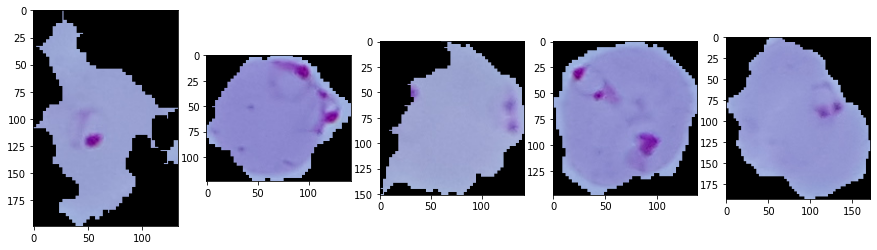

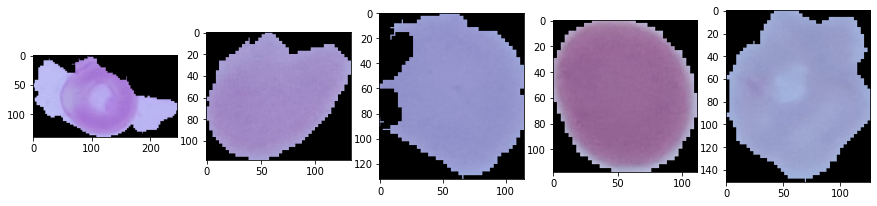

In [ ]:
import matplotlib.pyplot as plt
import random

def visualise_images(data_df,target):
  image_l = list(data_df[data_df['type']==target]['image'])
  # print(image_l)
  img_l = random.sample(image_l, 5)
  print(target,' images')
  f, axarr = plt.subplots(1,5,figsize=(15,15))
  # f.suptitle(target + ' images', fontsize=16)
  axarr[0].imshow(img_l[0])
  axarr[1].imshow(img_l[1])
  axarr[2].imshow(img_l[2])
  axarr[3].imshow(img_l[3])
  axarr[4].imshow(img_l[4])
  f.savefig(target+'.png')

visualise_images(data_df,type_a)
visualise_images(data_df,type_b)

###1.2 Implement a CNN architecture with blockA [9x9] followed by fully connected layer,blockB [6x6] followed by max pooling, blockC [3x3] followed by fully connected layer and finally a sigmoid layer.

In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def convertToTensor(s,perm=False):
  # for tensorflow
  # s = tf.constant(s.to_list())
  # for pytorch
  tensor = torch.Tensor(s.tolist())
  if perm:
    tensor = tensor.permute(0,3, 1, 2)
  else:
    tensor = tensor.type(torch.uint8)   
  return tensor

def getDataLoader(X,y,batch_size=64, shuffle=True):
  dataset = TensorDataset(X,y)
  dataloader = DataLoader(dataset,batch_size=64, shuffle=True)
  return dataloader

# resizing the images
image_l = list(data_df['image'])
res_image_l = []
for img in image_l:
  res_img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
  res_img = res_img/255.0
  # res_img = tf.constant(res_img)
  res_image_l.append(res_img)

res_data_df = pd.DataFrame({'image':res_image_l,'type':data_df['type']})

# splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(res_data_df, target = 'type',train_size=0.8, valid_size=0.1, test_size=0.1)
X_train = convertToTensor(X_train['image'],True)
X_valid = convertToTensor(X_valid['image'],True)
X_test = convertToTensor(X_test['image'],True)
y_train = convertToTensor(y_train)
y_valid = convertToTensor(y_valid)
y_test = convertToTensor(y_test)


train_dataloader = getDataLoader(X_train,y_train) 
val_dataloader = getDataLoader(X_valid,y_valid,False)
test_dataloader = getDataLoader(X_test,y_test,False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

def initialize_weights_ones(m):
  if isinstance(m, nn.Conv2d):
      nn.init.ones_(m.weight.data,nonlinearity='relu')
  elif isinstance(m, nn.Linear):
      nn.init.ones_(m.weight.data)

def plotTrainGraphs(title,history, epochs,image_path=None):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']

  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
  fig.suptitle(title)
  ax1.set_title('Accuracy Plot')
  ax1.plot(acc,label='Train')
  ax1.plot(val_acc,label='Val')
  ax1.legend(loc="upper right")
  ax1.set(xlabel='epoch', ylabel='accuracy')
  ax1.set_title('Accuracy Plot')
  ax2.plot(loss,label='Train')
  ax2.plot(val_loss,label='Val')
  ax2.legend(loc="upper right")
  ax2.set(xlabel='epoch', ylabel='loss')
  ax2.set_title('Loss Plot')
  if image_path is not None:
    fig.savefig(image_path+'.png')
  fig.show()

class CNN(nn.Module): 
    def __init__(self,dropout = '',drate = 0.4,weight_ini=None):
        super(CNN, self).__init__()
        self.dropout = dropout
        self.drate = drate
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        if dropout == 'afterconv':
          self.conv1_drop = nn.Dropout2d(p=drate)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        if dropout == 'afterconv':
          self.conv2_drop = nn.Dropout2d(p=drate)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
        if dropout == 'afterconv':
          self.conv3_drop = nn.Dropout2d(p=drate)
        self.fc1 = nn.Linear(80, 30)
        if dropout == 'betweendense':
          self.fc1_drop = nn.Dropout(p=drate)
        self.fc2 = nn.Linear(30, 2)

        if(weight_ini is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                  if weight_ini=='zero':
                    nn.init.zeros_(m.weight)
                  elif weight_ini=='random':
                    nn.init.normal_(m.weight)
                  else:
                    nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        if self.dropout=='afterconv':
          x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        else:
          x = F.relu(F.max_pool2d(self.conv1(x), 2))
        if self.dropout=='afterconv':
          x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        else:
          x = F.relu(F.max_pool2d(self.conv2(x), 2))
        if self.dropout=='afterconv':
          x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        else:
          x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        if self.dropout == 'betweendense':
          x = self.fc1_drop(x)
        x = F.sigmoid(self.fc2(x))
        return x
    
    def compute_l1_loss(self, w):
      return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
      return torch.square(w).sum()

def trainPytorchModel(model,train_dataloader,val_dataloader,device,optimizer,criterion,kernel_reg='',epochs=10):
  # %%time
  # keeping-track-of-losses 
  train_losses = []
  valid_losses = []
  train_acc_l = []
  valid_acc_l = []

  for epoch in range(1, epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc= 0.0
    valid_acc = 0.0
    # training-the-model
    model.train()
    for data, target in train_dataloader:
      # move-tensors-to-GPU 
      data = data.to(device)
      target = target.to(device)
      # clear-the-gradients-of-all-optimized-variables
      optimizer.zero_grad()
      # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
      output = model(data)
      # calculate-the-batch-loss
      loss = criterion(output, target)

      if kernel_reg=='l1':
        # Compute L1 loss component
        l1_weight = 0.00005
        l1_parameters = []
        for parameter in model.parameters():
            l1_parameters.append(parameter.view(-1))
        l1 = l1_weight * model.compute_l1_loss(torch.cat(l1_parameters))
        # Add L1 loss component
        loss += l1

        # l1_crit = nn.L1Loss(size_average=False)
        # reg_loss = 0
        # for param in model.parameters():
        #     reg_loss += l1_crit(param,target=torch.zeros_like(param))
        # factor = 0.0005
        # loss += factor * reg_loss

      if kernel_reg=='l2':
        # Compute l2 loss component
        l2_weight = 0.00005
        l2_parameters = []
        for parameter in model.parameters():
            l2_parameters.append(parameter.view(-1))
        l2 = l2_weight * model.compute_l2_loss(torch.cat(l2_parameters))
        # Add l2 loss component
        loss += l2

      # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
      loss.backward()
      # perform-a-ingle-optimization-step (parameter-update)
      optimizer.step()
      # update-training-loss
      train_loss += loss.item() * data.size(0)
      # col_output = torch.argmax(output)
      _, col_output = torch.max(output.data, 1)
      train_acc += (col_output == target).float().sum()
    
    # validate-the-model
    model.eval()
    for data, target in val_dataloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
        # col_output = torch.argmax(output)
        _, col_output = torch.max(output.data, 1)
        valid_acc += (col_output == target).float().sum()
    
    # calculate-average-losses
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(val_dataloader.sampler)
    train_acc = train_acc/len(train_dataloader.sampler)
    valid_acc = valid_acc/len(val_dataloader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc_l.append(train_acc)
    valid_acc_l.append(valid_acc)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(epoch, train_loss, valid_loss,train_acc,valid_acc))
  history = {'accuracy':train_acc_l,'val_accuracy':valid_acc_l,'loss':train_losses,'val_loss':valid_losses}
  return history,model

def testPyTorchModel(model,test_dataloader,criterion,device):
  # test-the-model
  model.eval()  # it-disables-dropout
  with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0.0
    for images, labels in test_dataloader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      test_loss += loss.item() * images.size(0)
    return correct/total,test_loss/total


def runAlgo(title,train_dataloader,val_dataloader, test_dataloader,epochs=10,model_path='',learning_rate=0.001,dropout='',drate=0.4,weight_ini=None,kernel_reg=''):
  model = CNN(dropout = dropout,drate = drate,weight_ini=weight_ini)
  print(model)
  # model.apply(initialize_weights_ones)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print(device)
  model = CNN().to(device)
  criterion = nn.CrossEntropyLoss()
  # if(kernel_reg=='l2'):
  #   # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.003)
  #   optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate,weight_decay=0.003)
  # else:
  #   # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
  
  history,model = trainPytorchModel(model,train_dataloader,val_dataloader,device,optimizer,criterion,kernel_reg=kernel_reg,epochs=epochs)
  plotTrainGraphs(title,history,epochs,image_path=model_path)
  acc,loss = testPyTorchModel(model,test_dataloader,criterion,device)
  print('Test Stats....')
  print('Test Accuracy = ',acc)
  print('Test Loss = ',loss)
  if model_path is not None:
    torch.save(model,model_path)
  print('*******************************')
  return model,history,loss,acc

###1.3 Initialize your neural network weights by using following initialization methods:

a. Zero initialization
b. Random Initialization
c. He initialization

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=80, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)
cpu
Epoch: 1 	Training Loss: 0.692724 	Validation Loss: 0.685228 	Training Acc: 0.512128 	Validation Acc: 0.548000
Epoch: 2 	Training Loss: 0.642307 	Validation Loss: 0.634567 	Training Acc: 0.644786 	Validation Acc: 0.633000
Epoch: 3 	Training Loss: 0.616550 	Validation Loss: 0.596392 	Training Acc: 0.671168 	Validation Acc: 0.686000
Epoch: 4 	Training Loss: 0.575416 	Validation Loss: 0.542011 	Training Acc: 0.726057 	Validation Acc: 0.761000
Epoch: 5 	Training Loss: 0.509000 	Validation Loss: 0.478283 	Training Acc: 0.802201 	Validation Acc: 0.858000
Epoch: 6 	Training Loss: 0.454478 	Validation Loss: 0.424945 	Training Acc: 0.860215 	Validation Acc: 0.891000
Epoch: 7 	Training Los

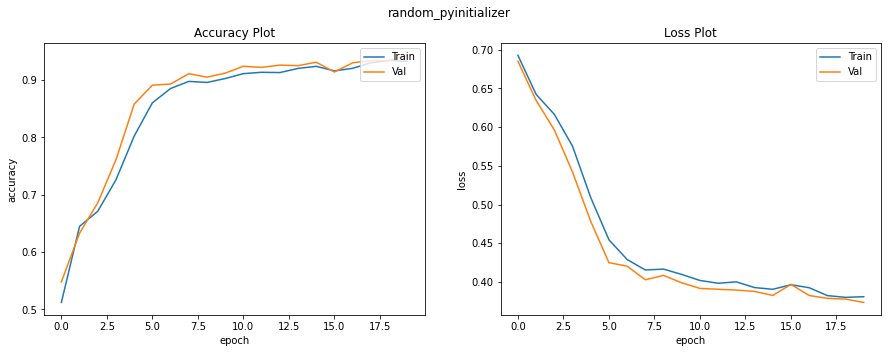

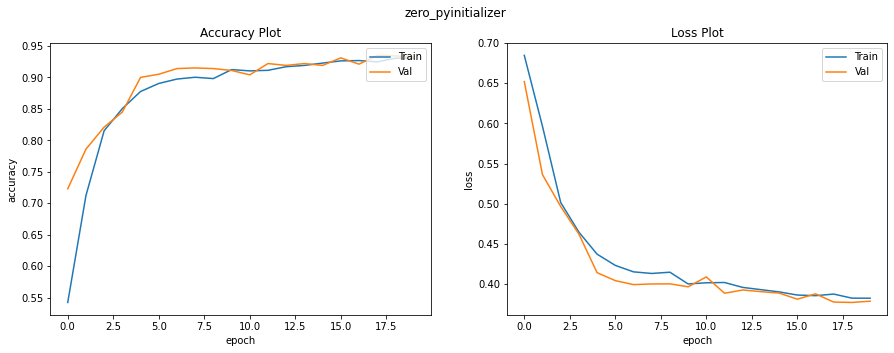

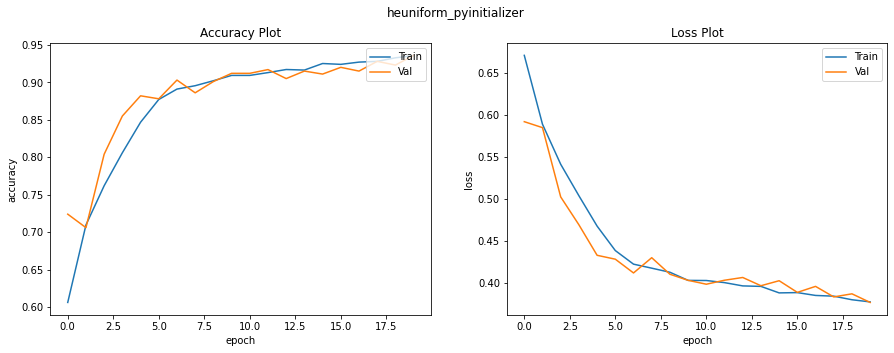

In [ ]:
initializer_d = {'random':'random','zero':'zero','heuniform':'he_uniform'}
epochs = 20
for key in initializer_d:
  title = key + '_'+'pyinitializer'
  model_path = model_path_folder + title
  model,history,_,_= runAlgo(title,train_dataloader,val_dataloader, test_dataloader,epochs=epochs,model_path=model_path,learning_rate=0.001,dropout='',drate=0.4,weight_ini=initializer_d[key],kernel_reg='')

###1.4 Implement Dropout and use i) After convolutional layers, ii) Between fully connected layers. Compare the performance in both the cases.

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=80, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)
cpu
Epoch: 1 	Training Loss: 0.663700 	Validation Loss: 0.594934 	Training Acc: 0.601150 	Validation Acc: 0.716000
Epoch: 2 	Training Loss: 0.585297 	Validation Loss: 0.565176 	Training Acc: 0.710178 	Validation Acc: 0.724000
Epoch: 3 	Training Loss: 0.560772 	Validation Loss: 0.570213 	Training Acc: 0.739685 	Validation Acc: 0.731000
Epoch: 4 	Training Loss: 0.547546 	Validation Loss: 0.520423 	Training Acc: 0.755439 	Validation Acc: 0.785000
Epoch: 5 	Training Loss: 0.521706 	Validation Loss: 0.488228 	Training Acc: 0.784571 	Validation Acc

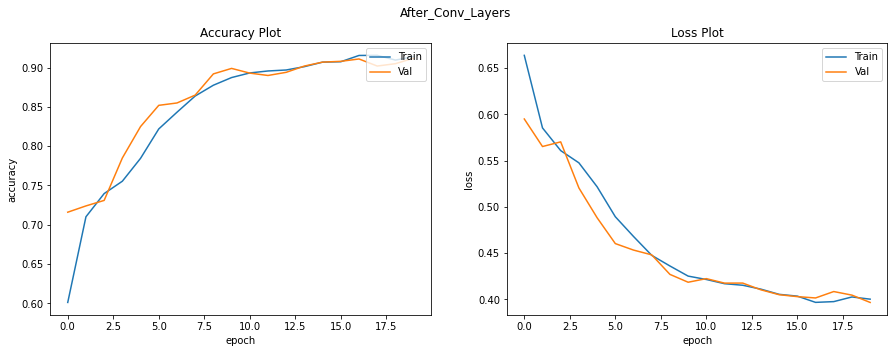

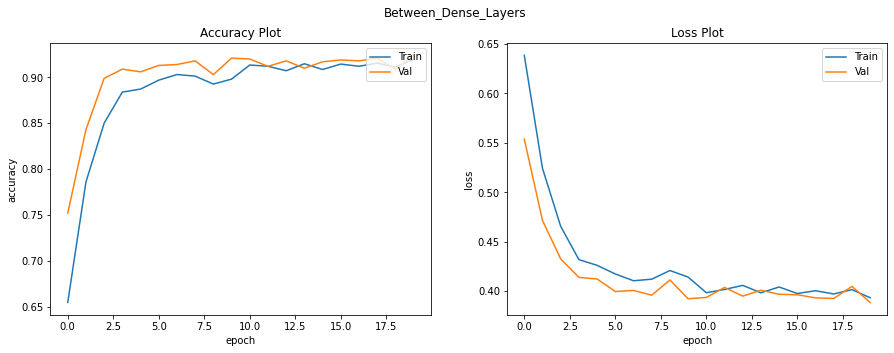

In [ ]:
dropout_d = {'After_Conv_Layers':'afterconv','Between_Dense_Layers':'betweendense'}
for key in dropout_d:
  title = key 
  model_path = model_path_folder + 'py'+title
  model,history,_,_= runAlgo(title,train_dataloader,val_dataloader, test_dataloader,epochs=epochs,model_path=model_path,learning_rate=0.001,dropout=dropout_d[key],drate=0.2,weight_ini=None,kernel_reg='')

###1.5 Keeping the above architecture same, implement the following regularizations and do a
thorough analysis on the output of each one of them:
a. L1 Regularization
b. L2 Regularization
Compare the performance in both the cases. Which regularization is better and why?

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=80, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
)
cpu
Epoch: 1 	Training Loss: 0.697204 	Validation Loss: 0.676791 	Training Acc: 0.540510 	Validation Acc: 0.598000
Epoch: 2 	Training Loss: 0.633912 	Validation Loss: 0.605150 	Training Acc: 0.655289 	Validation Acc: 0.688000
Epoch: 3 	Training Loss: 0.616210 	Validation Loss: 0.593383 	Training Acc: 0.678920 	Validation Acc: 0.704000
Epoch: 4 	Training Loss: 0.608228 	Validation Loss: 0.586344 	Training Acc: 0.688672 	Validation Acc: 0.712000
Epoch: 5 	Training Loss: 0.601541 	Validation Loss: 0.577925 	Training Acc: 0.700300 	Validation Acc: 0.725000
Epoch: 6 	Training Loss: 0.588502 	Validation Loss: 0.561607 	Training Acc: 0.717304 	Validation Acc: 0.741000
Epoch: 7 	Training Los

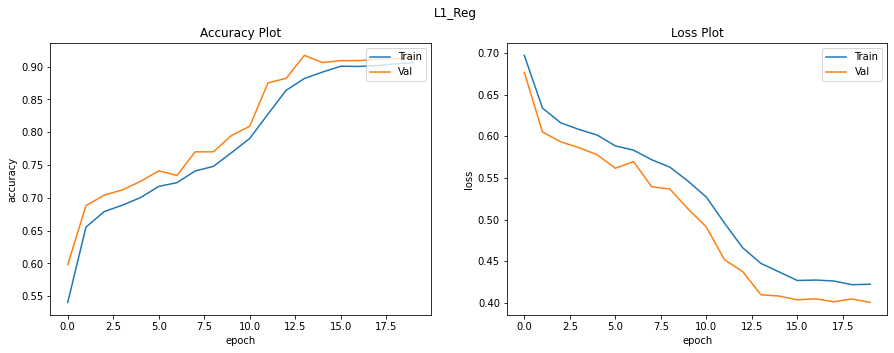

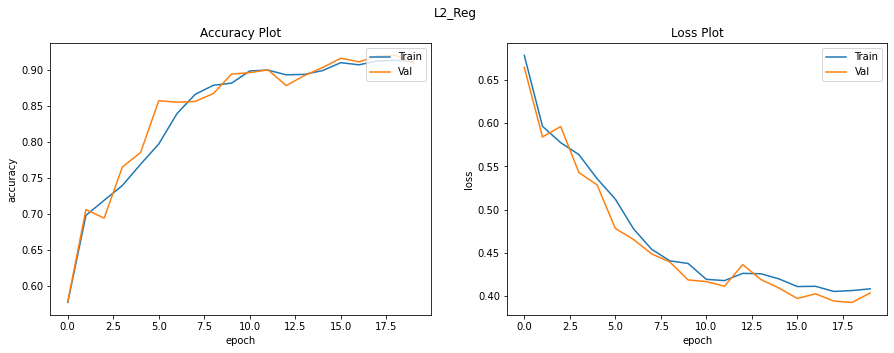

In [ ]:
reg_d =  {'L1_Reg':'l1','L2_Reg':'l2'}
for key in reg_d:
  title = key 
  model_path = model_path_folder +'py'+title
  model,history,_,_= runAlgo(title,train_dataloader,val_dataloader, test_dataloader,epochs=epochs,model_path=model_path,learning_rate=0.001,dropout='',drate=0.4,weight_ini=None,kernel_reg=reg_d[key])

# Question 2

In [ ]:
train_file = '/content/drive/MyDrive/Deep_Learning/Assg2/data_part2/train.csv'
test_file = '/content/drive/MyDrive/Deep_Learning/Assg2/data_part2/test.csv'
out_folder = '/content/drive/MyDrive/Deep_Learning/Assg2/saved_models/part2/'
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
train_df

,utterance,act
0,"Say , Jim , how about going for a few beers af...",3
1,You know that is tempting but is really not g...,4
2,What do you mean ? It will help us to relax .,2
3,Do you really think so ? I don't . It will ju...,2
4,I guess you are right.But what shall we do ? ...,2
...,...,...
5085,Tom and Helen got married at last .,1
5086,How did you know that ? I heart Tom ’ s fathe...,2
5087,I was invited to attend their wedding .,1
5088,It ’ s great . Although his father didn ’ t a...,1


###2.1Visualize dialogue corpus and show stats of the train and test file.

Train Data
No of utterances in Train data =  5090
Avg length of sentences (in chars) =  62
Avg length of sentences (in words) =  15
Max length of sentence =  550
Min length of sentence =  5
Vocab size =  5819
No of sentences for act 1  are =  2859
No of sentences for act 2  are =  1497
No of sentences for act 3  are =  426
No of sentences for act 4  are =  308

Test Data
No of utterances in Train data =  722
Avg length of sentences (in chars) =  61
Avg length of sentences (in words) =  15
Max length of sentence =  474
Min length of sentence =  6
Vocab size =  1781
No of sentences for act 1  are =  363
No of sentences for act 2  are =  217
No of sentences for act 3  are =  83
No of sentences for act 4  are =  59

train


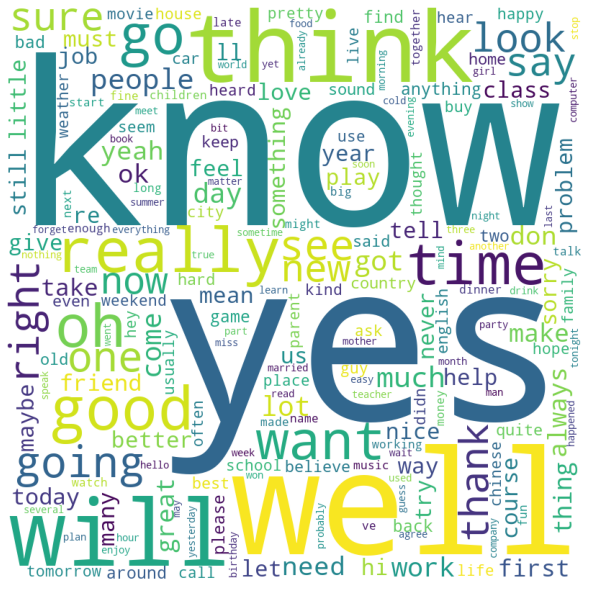

1


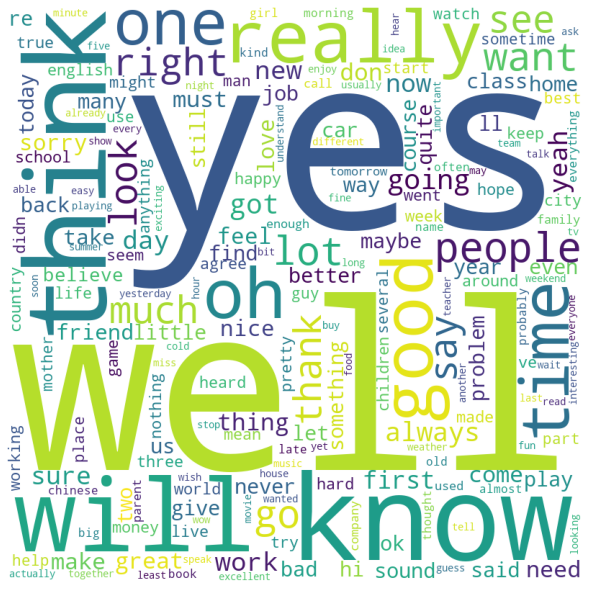

2


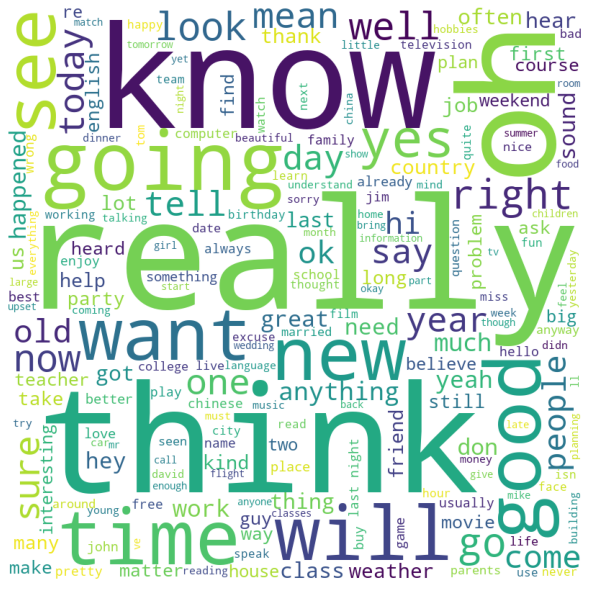

3


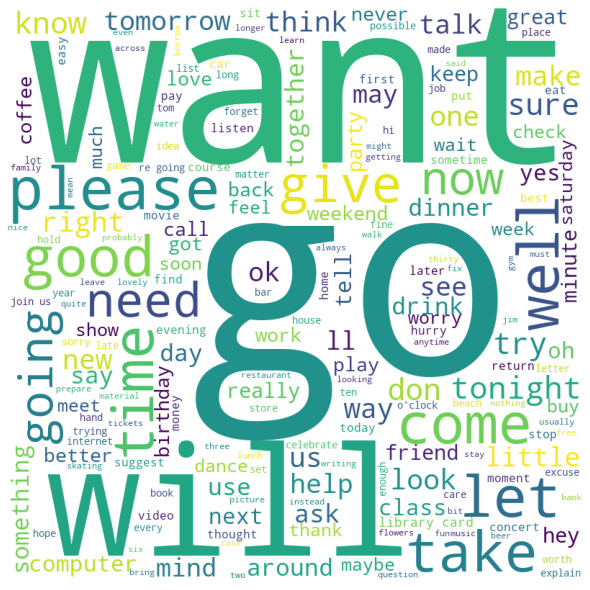

4


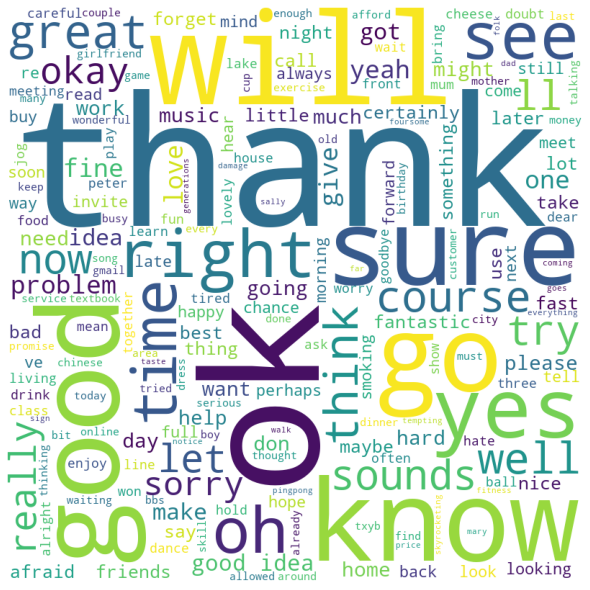

In [ ]:
# make word cloud

def printStats(df,title):
  print(title)
  print('No of utterances in Train data = ',len(df))
  avg_len = 0
  avg_wl = 0
  max_len = 0
  min_len = 100000
  vocab = []
  for sent in df.utterance:
    sent = str(sent)
    x = len(sent.split(' '))
    avg_len += len(sent)
    avg_wl += x
    max_len = max(max_len,len(sent))
    min_len = min(min_len,len(sent))
    vocab.extend(sent.split(' '))
  avg_len /= len(df)
  avg_wl /= len(df)
  print('Avg length of sentences (in chars) = ',int(avg_len))
  print('Avg length of sentences (in words) = ',int(avg_wl)) 
  print('Max length of sentence = ',int(max_len))
  print('Min length of sentence = ',int(min_len))
  print('Vocab size = ',len(set(vocab)))
  act_val = list(set(df['act'].tolist()))
  for act in act_val:
    print('No of sentences for act', act,' are = ',len(df[df.act==act]))
  print()

def createWordCloud(l,save_path,title):
  STOPWORDS = set(stopwords.words('english'))
  print(title)
  comment_words = ''
  stopwords = set(STOPWORDS)
  # iterate through the csv file
  for val in l:
      # typecaste each val to string
      val = str(val)
      # split the value
      tokens = val.split()
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      comment_words += " ".join(tokens)+" "
  wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(comment_words)
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.savefig(save_path)
  plt.show()

printStats(train_df,'Train Data')
printStats(test_df,'Test Data')

title = 'train'
createWordCloud(train_df.utterance.tolist(),out_folder+title+'wc.png',title)
act_val = list(set(train_df['act'].tolist()))
for act in act_val:
  custom_df = train_df[train_df.act==act]
  createWordCloud(custom_df.utterance.tolist(),out_folder+str(act)+'wc.png',act)

###2.2Implement a program using just LSTM and linear layers to predict act of utterance at time T considering previous X utterances’ context.

******** Model considering 0 Utterances ************
No of labels =  5090
No of articles =  5090

trainLabels
(5090, 4)

No of labels =  722
No of articles =  722

testLabels
(722, 4)

Length of Text Vocabulary: 5819
Vector size of Text Vocabulary:  torch.Size([5819, 200])
Label Length: 4
RNN(
  (embedding): Embedding(5819, 200)
  (lstm): LSTM(200, 32, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (act): Sigmoid()
)
Epoch: 0 : Train Loss: 1.2513 | Train Acc: 0.5390 | Train f1: 0.4140 | Val. Loss: 1.1599 |  Val. Acc: 0.5648 | Val f1: 0.4190
Epoch: 1 : Train Loss: 1.1491 | Train Acc: 0.5613 | Train f1: 0.4059 | Val. Loss: 1.1415 |  Val. Acc: 0.5648 | Val f1: 0.4190
Epoch: 2 : Train Loss: 1.1312 | Train Acc: 0.5613 | Train f1: 0.4056 | Val. Loss: 1.1225 |  Val. Acc: 0.5635 | Val f1: 0.4197
Epoch: 3 : Train Loss: 1.0986 | Train Acc: 0.5691 | Train f1: 0.4225 | Val. Loss: 1.1226 |  Val. Acc: 0.5967 | Val f1: 0.54

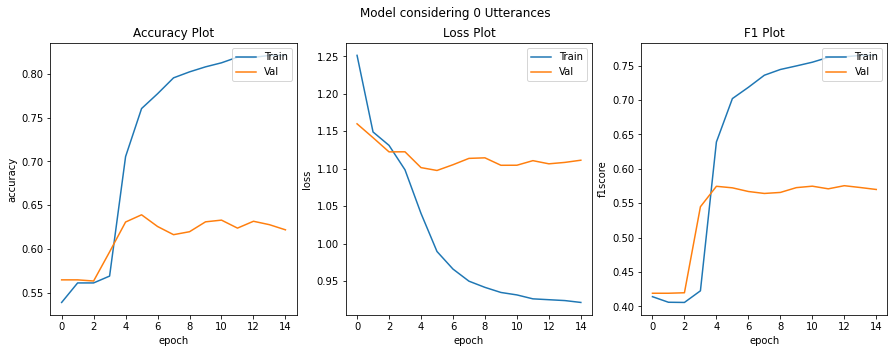

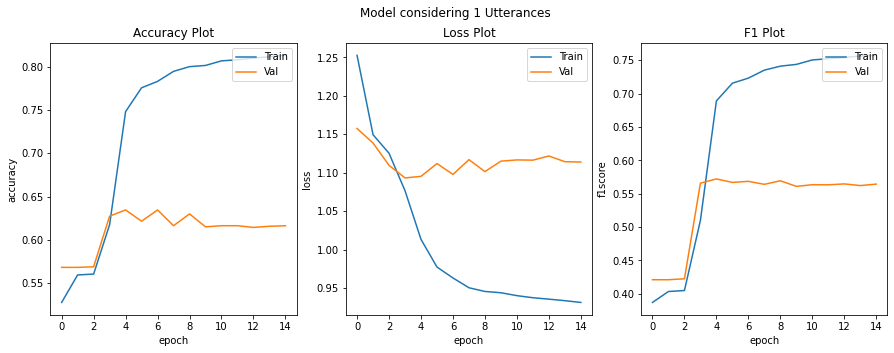

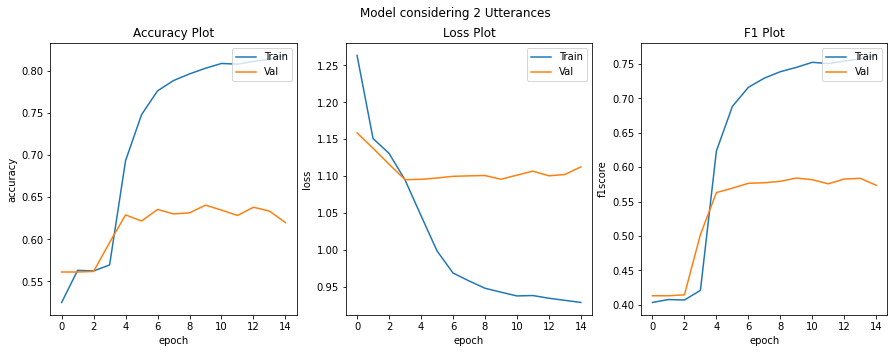

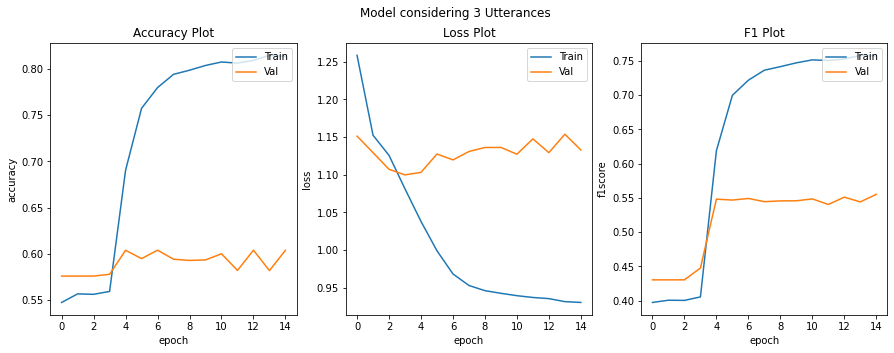

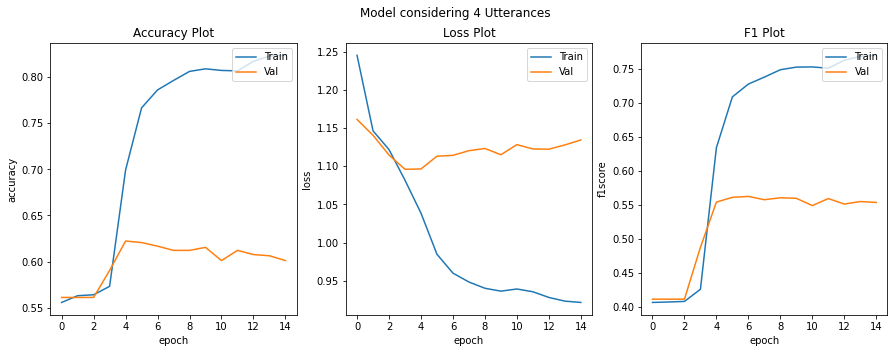

In [ ]:
# train_file = '/content/drive/MyDrive/Deep_Learning/Assg2/data_part2/train.csv'
# test_file = '/content/drive/MyDrive/Deep_Learning/Assg2/data_part2/test.csv'
# out_folder = '/content/drive/MyDrive/Deep_Learning/Assg2/saved_models/part2/'
# train_df = pd.read_csv(train_file)
# test_df = pd.read_csv(test_file)

def preprocessText(df):
  df['utterance'] = df['utterance'].str.lower()
  df['utterance'] = df['utterance'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x)) 
  df['utterance'] = df['utterance'].apply(lambda x: re.sub('W*dw*','',x))
  stop_words = set(stopwords.words('english'))
  stop_words.add('subject')
  stop_words.add('http')
  def remove_stopwords(text):
      return " ".join([word for word in str(text).split() if word not in stop_words])
  df['utterance'] = df['utterance'].apply(lambda x: remove_stopwords(x))
  # df['utterance'] = df['utterance'].apply(lambda x: re.sub('b[w-.]+?@w+?.w{2,4}b', 'emailadd',x))
  # df['utterance'] = df['utterance'].apply(lambda x:re.sub('(http[s]?S+)|(w+.[A-Za-z]{2,4}S*)', 'urladd', x))
  # stemmer = PorterStemmer()
  # def stem_words(text):
  #     return " ".join([stemmer.stem(word) for word in text.split()])
  # df['utterance'] = df['utterance'].apply(lambda x: stem_words(x))
  
  lemmatizer = WordNetLemmatizer()
  def lemmatize_words(text):
      return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
  df['utterance'] = df['utterance'].apply(lambda text: lemmatize_words(text))
  df['utterance'] = df['utterance'].apply(lambda text: re.sub(' +', ' ', text))
  return df

def getDataSetInFormOfList(df,X=0):
  n = len(df)
  articles = []
  labels = []

  for i in range(X,n):
    text = ''
    for j in range(i-X,i+1):
      text = df.iloc[j]['utterance'] + '<eos>'
    articles.append(text)
    labels.append(df.iloc[i]['act'])
  print('No of labels = ',len(labels))
  print('No of articles = ',len(articles))
  print()
  return articles,labels

def trainTestSplit(X,y,split=0.2):
  train_articles,val_articles, train_labels,val_labels = train_test_split(X, y, test_size=split, random_state=42)
  return train_articles,train_labels, val_articles, val_labels

# def coverttoSeqAndPaddSeq(tokenizer,art_l,max_length,padding_type,trunc_type,data_type='train'):
#   print(data_type)
#   sequences = tokenizer.texts_to_sequences(art_l)
#   padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#   print('No of sequences = ',len(sequences))
#   print('Shape of padded = ',padded.shape)
#   print()
#   return sequences, padded 

def covertLables(label_tokenizer,labels,data_type='train'):
  labels = np.array(labels).reshape(-1,1)
  label_seq = label_tokenizer.transform(labels)
  print(data_type + 'Labels')
  # print(len(label_seq))
  print(label_seq.shape)
  print()
  return label_seq

def getDataIterables(train_df,test_df,X,out_folder,device):
  clean_train_df = preprocessText(train_df)
  articles,labels = getDataSetInFormOfList(clean_train_df,X)

  # one hot encoding of the labels
  label_tokenizer = OneHotEncoder()
  labels2d = np.array(labels).reshape(-1,1)
  label_tokenizer.fit(labels2d)
  train_label_seq = covertLables(label_tokenizer,labels,'train')
  
  pytrain_df = pd.DataFrame({'sent':articles,'label':train_label_seq})

  clean_test_df = preprocessText(test_df)
  test_art,test_labels = getDataSetInFormOfList(clean_test_df,X)
  test_label_seq = covertLables(label_tokenizer,test_labels,'test')
  pytest_df = pd.DataFrame({'sent':test_art,'label':test_label_seq})

  pytrain_df.to_csv(out_folder+'pytrain.csv',index=False)
  pytest_df.to_csv(out_folder+'pytest.csv',index=False)

  # create Data Fields 
  tokenize = lambda x: x.split()
  TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
  LABEL = data.LabelField()

  # divide the data into train and test
  fields = {'sent':('sent',TEXT),'label':('label',LABEL)}
  train_data, test_data = TabularDataset.splits(
      path='',
      train=out_folder+'pytrain.csv',
      test=  out_folder+'pytest.csv',
      format = 'csv',
      fields = fields)
  TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=200))
  LABEL.build_vocab(train_data)

  word_embeddings = TEXT.vocab.vectors

  print ("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
  print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
  print ("Label Length: " + str(len(LABEL.vocab)))

  train_data, valid_data = train_data.split() # Further splitting of training_data to create new training_data & validation_data
  train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=64, sort_key=lambda x: len(x.sent), repeat=False, shuffle=True,device=device)
  vocab_size = len(TEXT.vocab)
  return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter


def plotRNNTrainGraphs(title,history, epochs,image_path=None):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  f1 = history['f1_score']
  val_f1 = history['val_f1_score']

  fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))
  fig.suptitle(title)
  ax1.set_title('Accuracy Plot')
  ax1.plot(acc,label='Train')
  ax1.plot(val_acc,label='Val')
  ax1.legend(loc="upper right")
  ax1.set(xlabel='epoch', ylabel='accuracy')
  ax1.set_title('Accuracy Plot')
  ax2.plot(loss,label='Train')
  ax2.plot(val_loss,label='Val')
  ax2.legend(loc="upper right")
  ax2.set(xlabel='epoch', ylabel='loss')
  ax2.set_title('Loss Plot')
  ax3.plot(f1,label='Train')
  ax3.plot(val_f1,label='Val')
  ax3.legend(loc="upper right")
  ax3.set(xlabel='epoch', ylabel='f1score')
  ax3.set_title('F1 Plot')
  if image_path is not None:
    fig.savefig(image_path+'.png')
  fig.show()

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,num_layers=n_layers,bidirectional=bidirectional,dropout=dropout,batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True,enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)
        #Final activation function
        outputs=self.act(dense_outputs)
        return outputs


def train(model, iterator, optimizer, criterion):
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    #set the model in training phase
    model.train()  
    for batch in iterator:
        #resets the gradients after every batch
        optimizer.zero_grad()   
        #retrieve text and no. of words
        text, text_lengths = batch.sent
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        #compute the loss
        loss = criterion(predictions, batch.label)        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        #backpropage the loss and compute the gradients
        f1 = custom_f1_score(predictions,batch.label)
        loss.backward()       
        #update the weights
        optimizer.step()      
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        epoch_f1+=f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1/len(iterator)

def evaluate(model, iterator, criterion):
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    #deactivating dropout layers
    model.eval()
    #deactivates autograd
    with torch.no_grad():
        for batch in iterator:
            #retrieve text and no. of words
            text, text_lengths = batch.sent
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            f1 = custom_f1_score(predictions,batch.label)
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1/len(iterator)

#define metric
def binary_accuracy(preds, y):
    _, col_output = torch.max(preds, 1)
    correct = (col_output == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def custom_f1_score(preds, y):
    _, col_output = torch.max(preds, 1)
    return f1_score(y,col_output, average='weighted')

X_type = [0,1,2,3,4]
# X_type = [0,1]

for X in X_type:
  title = 'Model considering '+str(X)+' Utterances'
  print('********',title,'************')
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  vocab_size = 6000
  embedding_dim = 200
  # embedding_dim = 64 +  int(X*12)
  num_hidden_nodes = 32
  num_output_nodes = 4
  num_layers = 2
  bidirection = True
  dropout = 0.4
  N_EPOCHS = 15
  model_path = out_folder + 'x'+str(X)+'model'
  max_length = 200 + int(X*50)
  
  TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = getDataIterables(train_df,test_df,X,out_folder,device)

  #instantiate the model
  model = RNN(vocab_size, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, bidirectional = True, dropout = dropout)
  print(model)

  pretrained_embeddings = TEXT.vocab.vectors
  model.embedding.weight.data.copy_(pretrained_embeddings)

  optimizer = torch.optim.Adam(model.parameters())
  criterion = nn.CrossEntropyLoss()

  #push to cuda if available
  model = model.to(device)
  criterion = criterion.to(device)

  best_valid_loss = float('inf')
  train_loss_l = []
  val_loss_l= []
  train_acc_l = []
  val_acc_l = []
  train_f1_l = []
  val_f1_l = []

  for epoch in range(N_EPOCHS):
    #train the model
    train_loss, train_acc , train_f1 = train(model, train_iter, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iter, criterion)
    
    train_loss_l.append(train_loss)
    val_loss_l.append(valid_loss)
    train_acc_l.append(train_acc)
    val_acc_l.append(valid_acc)
    train_f1_l.append(train_f1)
    val_f1_l.append(valid_f1)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), out_folder+str(X)+'saved_weights.pt')
    
    print(f'Epoch: {epoch} : Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train f1: {train_f1:.4f} | Val. Loss: {valid_loss:.4f} |  Val. Acc: {valid_acc:.4f} | Val f1: {valid_f1:.4f}')
  
  history = {'accuracy':train_acc_l,'val_accuracy':val_acc_l,'loss':train_loss_l,'val_loss':val_loss_l,'f1_score':train_f1_l,'val_f1_score':val_f1_l}
  plotRNNTrainGraphs(title,history,N_EPOCHS,image_path=model_path)
  loss, acc, f1 = evaluate(model, test_iter, criterion)
  print('Test Stats....')
  print('Test Accuracy = ',acc)
  print('Test Loss = ',loss)
  print('Test f1 = ',f1)
  # if model_path is not None:
  #   torch.save(model,model_path)
  # print('*******************************')